# Sequential CRM Experiments

## Reference works
- ref paper: https://arxiv.org/pdf/1502.02362.pdf
- ref code & data: https://www.cs.cornell.edu/~adith/POEM/
- recent paper (ICML'18): http://proceedings.mlr.press/v80/wu18g/wu18g.pdf
- recent paper using vision tasks: https://arxiv.org/pdf/1806.11500v6.pdf

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import time
import copy

In [3]:
import numpy as np

In [4]:
import jax.numpy as jnp
from jax.scipy.special import expit as jexpit

In [5]:
import matplotlib.pyplot as plt

In [6]:
from dataset_utils import load_dataset
from baselines_skylines import result_table, make_baselines_skylines, stochastic_hamming_loss
from crm_dataset import CRMDataset
from crm_model import Model
from tracing_utils import LossHistory

---
### Loading dataset

In [7]:
# dataset_name='scene'
# dataset_name='yeast'
dataset_name='tmc2007'

X_train, y_train, X_test, y_test, labels = load_dataset(dataset_name, reduce_dim=200)

reducing dimension for TMC dataset
X_train: (21447, 200) y_train: (21447, 22)


### Baselines & Skylines

In [8]:
pi0, pistar = make_baselines_skylines(dataset_name, X_train, y_train, n_jobs=1)

# The Experiment

In [9]:
len(X_train)

21447

In [10]:
n_rollouts = 10
batch_size = int(len(X_train) / n_rollouts)
samples = list(range(0, len(X_train), batch_size))
n_replays = 10
n_rollouts, batch_size, samples

(10,
 2144,
 [0, 2144, 4288, 6432, 8576, 10720, 12864, 15008, 17152, 19296, 21440])

In [14]:
crm_losses

array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ],
       [1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ]])

In [15]:
i, j

(0, 10)

In [19]:
crm_losses = np.ones((10, len(samples)))
crm_rewards = np.ones((10, len(samples)))

test_sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X_test)]).T
crm_reward = CRMDataset().update_from_supervised_dataset(
    X_test, y_test, test_sampling_probas, n_samples=4
).rewards.sum() / (len(X_test)*y_test.shape[1]*4)

for i in range(10):
    np.random.seed(i*42+1000)
    print(i, end='')
    
    crm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    crm_dataset = CRMDataset()
        
    start = 0
    for j, end in enumerate(samples):
        print('.', end='')
        # current batch
        X = X_train[start:end, :]
        y = y_train[start:end, :]
        if end > start:
            # CRM play & data collection
            sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X)]).T 
            crm_dataset.update_from_supervised_dataset(X, y, sampling_probas, n_samples=n_replays)
            # learning
            crm_model.fit(
                crm_dataset, 
                lambda_ = .5,
                verbose = 0
            )
        # eval
        crm_losses[i,j] = crm_model.expected_hamming_loss(X_test, y_test)
        crm_rewards[i,j] = crm_reward
        # next round
        start = end
    print()

crm_losses = crm_losses.mean(axis=0)
crm_rewards = crm_rewards.mean(axis=0)
crm_losses, crm_rewards

0...........
1...........
2...........
3...........
4...........
5...........
6...........
7...........
8...........
9...........


(array([0.5       , 0.18059806, 0.14444239, 0.13887654, 0.12097187,
        0.15007269, 0.11736157, 0.09303119, 0.09711339, 0.09601287,
        0.09786935]),
 array([0.5180715, 0.5180715, 0.5180715, 0.5180715, 0.5180715, 0.5180715,
        0.5180715, 0.5180715, 0.5180715, 0.5180715, 0.5180715]))

In [24]:
scrm_losses = np.ones((10, len(samples)))
scrm_rewards = np.ones((10, len(samples)))

for i in range(10):
    np.random.seed(i*42+1000)
    print(i, end='')

    scrm_model = Model.null_model(X_test.shape[1], y_test.shape[1])
    scrm_dataset = CRMDataset()
    
    start = 0
    for j, end in enumerate(samples):
        print('.', end='')
        # current batch
        X = X_train[start:end, :]
        y = y_train[start:end, :]
        if end > start:
            # CRM play & data collection
            if j == 0:
                sampling_probas = np.array([_[:,1] for _ in pi0.predict_proba(X)]).T 
            else:
                sampling_probas = scrm_model.predict_proba(X, y)
            scrm_dataset.update_from_supervised_dataset(X, y, sampling_probas, n_samples=n_replays)
            # learning
            lambda_ = scrm_model.theoretical_exploration_bonus(batch_size*n_replays, len(X_train)*n_replays)
            scrm_model.fit(
                crm_dataset, 
                lambda_ = scrm_model.theoretical_exploration_bonus(len(scrm_dataset), n_replays * len(X_train)) * .01,
                verbose = 0
            )
        # eval
        scrm_losses[i,j] = scrm_model.expected_hamming_loss(X_test, y_test)
        scrm_rewards[i,j] = CRMDataset().update_from_supervised_dataset(
            X_test, y_test, scrm_model.predict_proba(X_test, np.ones_like(y_test)), n_samples=4
        ).rewards.sum()  / (len(X_test)*y_test.shape[1]*4)
        # next round
        start = end
    print()

scrm_losses = scrm_losses.mean(axis=0)
scrm_rewards = scrm_rewards.mean(axis=0)
scrm_losses, scrm_rewards

0...........
1...........
2...........
3...........
4...........
5...........
6...........
7...........
8...........
9...........


(array([0.5       , 0.08917178, 0.09014439, 0.08962935, 0.08904518,
        0.08975365, 0.08971422, 0.09015417, 0.08994222, 0.09015899,
        0.08937839]),
 array([0.50016627, 0.91081858, 0.90985834, 0.91038019, 0.91095655,
        0.91025016, 0.91027893, 0.90985039, 0.91004845, 0.90984244,
        0.91061639]))

In [25]:
baseline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        np.array([_[:,1] for _ in pi0.predict_proba(X_test)]).T, n_samples=4
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
for _ in range(10)])
baseline_rewards = np.ones_like(crm_losses)*baseline_reward

skyline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        np.array([_[:,1] for _ in pistar.predict_proba(X_test)]).T, n_samples=4
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*4)
for _ in range(10)])
skyline_rewards = np.ones_like(crm_losses)*skyline_reward

map_skyline_reward = np.mean([
    CRMDataset().update_from_supervised_dataset(
        X_test, y_test, 
        pistar.predict(X_test), n_samples=1
    ).rewards.sum() / (len(X_test)*y_test.shape[1]*1)
for _ in range(10)])
map_skyline_rewards = np.ones_like(crm_losses)*map_skyline_reward

baseline_loss = stochastic_hamming_loss(pi0, X_test, y_test)
skyline_loss = stochastic_hamming_loss(pistar, X_test, y_test)

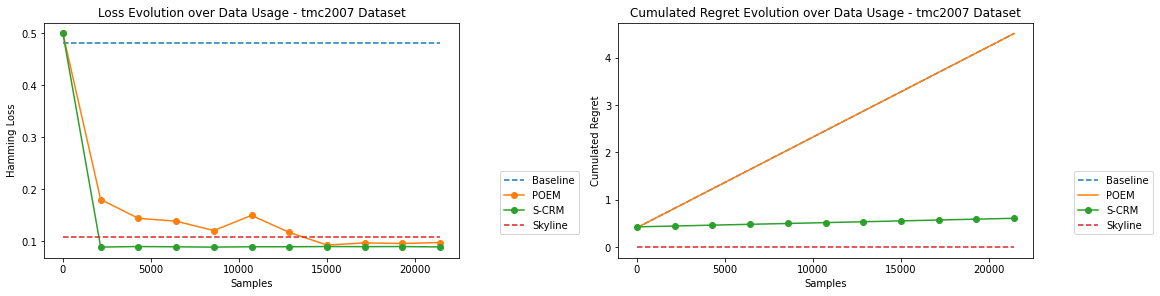

In [32]:
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True, figsize=(16,4))

ax1.set_title('Loss Evolution over Data Usage - %s Dataset' % dataset_name)
ax1.set_xlabel('Samples')
ax1.plot(samples, np.ones_like(crm_losses)*baseline_loss, '--', label='Baseline')
ax1.plot(samples, crm_losses, 'o-', label='POEM')
# ax1.plot(samples[1:], ucrm_losses, 'o-', label='POEM + Unif. Explo.')
ax1.plot(samples, scrm_losses, 'o-', label='S-CRM')
ax1.plot(samples, np.ones_like(crm_losses)*skyline_loss, '--', label='Skyline')
#ax1.plot(samples, np.ones_like(crm_losses)*map_skyline_loss, '--', label='Skyline (MAP)')
ax1.set_ylabel('Hamming Loss')
ax1.legend(loc=(1.1, .1))

ax2.set_title('Cumulated Regret Evolution over Data Usage - %s Dataset' % dataset_name)
ax2.set_xlabel('Samples')
#ax2.set_yscale('log')
ax2.plot(samples, np.cumsum(map_skyline_rewards) - np.cumsum(np.ones_like(crm_losses)*baseline_reward), '--', label='Baseline')
ax2.plot(samples, np.cumsum(map_skyline_rewards) - np.cumsum(crm_rewards), '-', label='POEM')
# ax2.plot(samples[1:], ucrm_rewards, 'o-', label='POEM + Unif. Explo.')
ax2.plot(samples, np.cumsum(map_skyline_rewards) - np.cumsum(scrm_rewards), 'o-', label='S-CRM')
ax2.plot(samples, np.zeros_like(skyline_rewards), '--', label='Skyline')
ax2.set_ylabel('Cumulated Regret')
ax2.legend(loc=(1.1, .1))